# 01 · EDA & Sentiment for H5N1 Digital Epidemiology

This notebook performs exploratory data analysis and sentiment/tone extraction on H5N1-related posts.
It is keyed to the CDC announcement on 2024-04-04 and prepares daily aggregates & plots for pre/post comparisons.

What you'll get:
- Column inference (time, text, user)
- Cleaning & structure features (hashtags, mentions, urls, lengths, retweet flag)
- Sentiment (VADER with a lexicon fallback)
- Tone features (fear, uncertainty, urgency, safety/trust)
- Daily aggregates + charts (with a vertical line at 2024-04-04)
- Pre vs post summary stats

In [5]:
!pip install vaderSentiment


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [2]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (override with env var H5N1_CSV_PATH if desired)
DATA_PATH = "../data/raw/H5N1_ -is_retweet since_2022-06-01 until_2025-01-01 lang_en.csv"

ANNOUNCE_DATE = pd.Timestamp("2024-04-04")

print("DATA_PATH:", DATA_PATH)
print("ANNOUNCE_DATE:", ANNOUNCE_DATE)

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Rows:", len(df))
df.head(3)

DATA_PATH: ../data/raw/H5N1_ -is_retweet since_2022-06-01 until_2025-01-01 lang_en.csv
ANNOUNCE_DATE: 2024-04-04 00:00:00
Rows: 183211


,_id,userId,userName,alias,profilePicture,userCreatedAt,bio,followers,following,lists,...,firstLink,images,impressions,isImage,firstImage,location,url,noteTweetText,retweetedUserId,reportName
0,1697387307949797665,1197585796775079936,Ishi Nobu い忍ふ,ishinobu_actual,https://pbs.twimg.com/profile_images/124190203...,2019-11-21T18:41:32.000Z,An independent polymath scholar & guru. My boo...,1058,121,23,...,https://www.nytimes.com/2023/08/31/opinion/bir...,[],120.0,False,NaN,Oregon (US),https://x.com/user/status/1697387307949797665,NaN,NaN,NaN
1,1697385383158260177,27540099,Eric W. Sanderson,ewsanderson,https://pbs.twimg.com/profile_images/128666077...,2009-03-30T00:18:46.000Z,VP Urban conservation @NYBG formerly @TheWCS. ...,3578,3313,164,...,https://nyti.ms/47XasiO,[],52.0,False,NaN,Bronx NY,https://x.com/user/status/1697385383158260177,NaN,NaN,NaN
2,1697384658231841182,796408675,Mary,awoofoflove,https://pbs.twimg.com/profile_images/256619801...,2012-09-01T16:21:39.000Z,The love of our dogs,389,874,4,...,http://dlvr.it/SvSQk3,[],98.0,False,NaN,NaN,https://x.com/user/status/1697384658231841182,NaN,NaN,NaN


## Column inference, normalization, and cleaning

In [10]:
df.dtypes

_id                           int64
userId                        int64
userName                     object
alias                        object
profilePicture               object
userCreatedAt        datetime64[ns]
bio                          object
followers                    object
following                    object
lists                        object
statusesCount                object
verified                     object
userLocation                 object
lang                         object
type                         object
text                         object
createdAt                    object
mentions                     object
totalRetweets                object
favorites                    object
replies                      object
links                        object
firstLink                    object
images                       object
impressions                 float64
isImage                      object
firstImage                   object
location                    

In [41]:
# ==== Predefine your columns here ===========================================
TEXT_COL = "text"     # e.g., "text", "full_text", "tweet_text"
TIME_COL = "createdAt"    # e.g., "created_at", "timestamp"
USER_COL = "username"      # or None if not present
LANG_COL = "lang"          # or None
RT_COL   = "totalRetweets"    # or None

# (Optional) define ANNOUNCE_DATE if not already set
try:
    ANNOUNCE_DATE
except NameError:
    ANNOUNCE_DATE = pd.Timestamp("2024-04-04")

# ==== Validate columns ======================================================
_required = {"TEXT_COL": TEXT_COL, "TIME_COL": TIME_COL}
_optional = {"USER_COL": USER_COL, "LANG_COL": LANG_COL, "RT_COL": RT_COL}

missing = [col for col in _required.values() if col not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in df: {missing}")

for label, col in _optional.items():
    if col is not None and col not in df.columns:
        print(f"Warning: {label}='{col}' not found in df.columns; ignoring.")
        _optional[label] = None

# Bind final names
text_col = TEXT_COL
time_col = TIME_COL
user_col = _optional["USER_COL"]
lang_col = _optional["LANG_COL"]
rt_col   = _optional["RT_COL"]

print(f"text_col: {text_col}")
print(f"time_col: {time_col}")
print(f"user_col: {user_col}")
print(f"lang_col: {lang_col}")
print(f"rt_col:   {rt_col}")

# ==== Normalize, filter, and derive fields =================================
df = (
    df.copy()
      .assign(**{
          time_col: pd.to_datetime(df[time_col], errors="coerce", utc=True).dt.tz_convert(None)
      })
      .dropna(subset=[time_col])
      .sort_values(time_col)
      .assign(**{
          text_col: df[text_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
      })
)

if lang_col:
    keep_lang = {"en", "eng", "english"}
    df = df[df[lang_col].astype(str).str.lower().isin(keep_lang) | df[lang_col].isna()]

df["date"] = df[time_col].dt.date
df["pre_post"] = np.where(df[time_col] < ANNOUNCE_DATE, "pre", "post")

# ==== Structure features ====================================================
df = df.assign(
    hashtag_count = df[text_col].str.count(r"#\w+"),
    mention_count = df[text_col].str.count(r"@\w+"),
    url_count     = df[text_col].str.count(r"http[s]?://"),
    char_len      = df[text_col].str.len(),
    token_len     = df[text_col].str.split().str.len(),
    is_retweet    = (
        df[rt_col].astype(str).str.lower().isin({"true", "1", "yes", "y", "t"})
        if rt_col else df[text_col].str.startswith("RT @")
    )
)

print(f"Time range: {df[time_col].min()} → {df[time_col].max()}")
print("Pre/Post counts:\n", df["pre_post"].value_counts())

df[[time_col, text_col, "pre_post", "hashtag_count", "mention_count", "url_count"]].head(5)


text_col: text
time_col: createdAt
user_col: None
lang_col: lang
rt_col:   totalRetweets
Time range: 2022-06-01 01:19:03 → 2024-12-31 23:59:41
Pre/Post counts:
 pre_post
post    134492
pre      48457
Name: count, dtype: int64


,createdAt,text,pre_post,hashtag_count,mention_count,url_count
0,2022-06-01 01:19:03,HPAI H5N1 found in some mammals in N America.P...,pre,0,0,1
1,2022-06-01 02:18:47,Emergence and Evolution of H5N1 Bird Flu | Avi...,pre,0,1,1
2,2022-06-01 05:57:04,Avian influenza (H5N1) was detected at a small...,pre,2,0,1
3,2022-06-01 08:53:53,The avian influenza virus A(H5N1) emerged in 1...,pre,0,0,1
4,2022-06-01 09:26:47,@shetlandnature @nature_scot @Natures_Voice @D...,pre,0,12,0


## Sentiment (VADER with fallback)

In [42]:
def compute_vader(texts: pd.Series):
    try:
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        scores = texts.apply(lambda t: analyzer.polarity_scores(str(t)))
        out = pd.DataFrame(scores.tolist(), index=texts.index)
        out = out.rename(columns={"compound":"sent_compound","pos":"sent_pos","neu":"sent_neu","neg":"sent_neg"})
        return out
    except Exception as e:
        print("VADER not available; using fallback lexicon:", str(e))
        return None

v = compute_vader(df[text_col])
if v is None:
    POS = {"good","great","excellent","helpful","effective","safe","recover","recovering","improve","progress","control","contained","decline","decrease","drop","reduce","resilient"}
    NEG = {"bad","terrible","awful","danger","dangerous","risk","panic","outbreak","spread","infected","infection","deadly","fatal","fear","worry","worried","concern","urgent","emergency","alert","alarm","anxious","unsafe"}
    def simple_scores(s):
        toks = str(s).lower().split()
        pos = sum(t in POS for t in toks)
        neg = sum(t in NEG for t in toks)
        tot = pos + neg
        comp = (pos - neg)/tot if tot>0 else 0.0
        return pd.Series({"sent_pos": pos, "sent_neg": neg, "sent_neu": max(0, len(toks)-tot), "sent_compound": comp})
    v = df[text_col].apply(simple_scores)

df = pd.concat([df, v], axis=1)
df[["sent_compound","sent_pos","sent_neu","sent_neg"]].describe()

,sent_compound,sent_compound,sent_pos,sent_pos,sent_neu,sent_neu,sent_neg,sent_neg
count,182949.000000,182949.000000,182949.000000,182949.000000,182949.000000,182949.000000,182949.000000,182949.000000
mean,-0.183561,-0.141513,0.063001,0.056030,28.781628,0.846355,0.297422,0.097613
std,0.486499,0.465660,0.260510,0.078708,13.256119,0.117759,0.584766,0.101249
min,-1.000000,-0.991900,0.000000,0.000000,1.000000,0.099000,0.000000,0.000000
25%,0.000000,-0.516000,0.000000,0.000000,17.000000,0.771000,0.000000,0.000000
50%,0.000000,-0.051600,0.000000,0.000000,29.000000,0.852000,0.000000,0.080000
75%,0.000000,0.112500,0.000000,0.096000,40.000000,0.938000,0.000000,0.158000
max,1.000000,0.992400,4.000000,0.861000,101.000000,1.000000,6.000000,0.856000


## Tone features

In [43]:
FEAR = {"fear","scared","afraid","panic","terrified","anxious","fright","hysteria"}
UNCERTAINTY = {"uncertain","uncertainty","unknown","unconfirmed","maybe","rumor","unclear","speculation","likely","possible","might"}
URGENCY = {"urgent","alert","emergency","warning","breaking","act now","immediately"}
SAFETY_TRUST = {"safe","safety","effective","guidance","cdc","who","public health","protocol","mask","vaccine","vaccination","prevent","prevention","mitigate","protection","trust"}

def count_terms(s, lex):
    t = str(s).lower()
    return sum(1 for w in lex if w in t)

df["tone_fear"]         = df[text_col].apply(lambda s: count_terms(s, FEAR))
df["tone_uncertainty"]  = df[text_col].apply(lambda s: count_terms(s, UNCERTAINTY))
df["tone_urgency"]      = df[text_col].apply(lambda s: count_terms(s, URGENCY))
df["tone_safety_trust"] = df[text_col].apply(lambda s: count_terms(s, SAFETY_TRUST))

df[["tone_fear","tone_uncertainty","tone_urgency","tone_safety_trust"]].describe()

,tone_fear,tone_uncertainty,tone_urgency,tone_safety_trust
count,182949.000000,182949.000000,182949.000000,182949.000000
mean,0.023990,0.066439,0.043553,0.354203
std,0.157178,0.264297,0.215840,0.647138
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000
max,3.000000,4.000000,3.000000,7.000000


## Daily aggregates & charts

In [44]:
df.columns

Index(['_id', 'userId', 'userName', 'alias', 'profilePicture', 'userCreatedAt',
       'bio', 'followers', 'following', 'lists', 'statusesCount', 'verified',
       'userLocation', 'lang', 'type', 'text', 'createdAt', 'mentions',
       'totalRetweets', 'favorites', 'replies', 'links', 'firstLink', 'images',
       'impressions', 'isImage', 'firstImage', 'location', 'url',
       'noteTweetText', 'retweetedUserId', 'reportName', 'date', 'pre_post',
       'hashtag_count', 'mention_count', 'url_count', 'char_len', 'token_len',
       'is_retweet', 'tone_fear', 'tone_uncertainty', 'tone_urgency',
       'tone_safety_trust', 'sent_pos', 'sent_neg', 'sent_neu',
       'sent_compound', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound'],
      dtype='object')

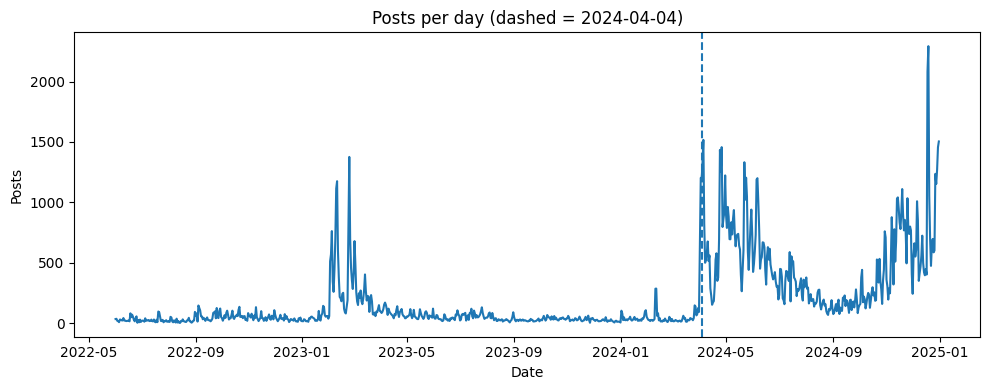

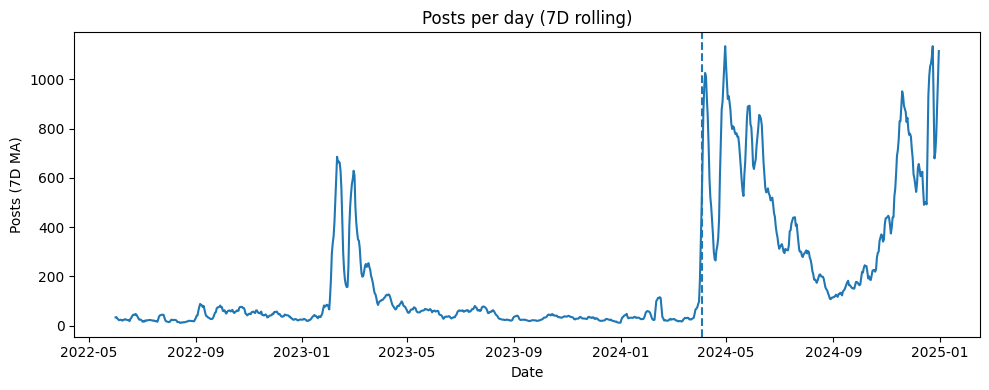

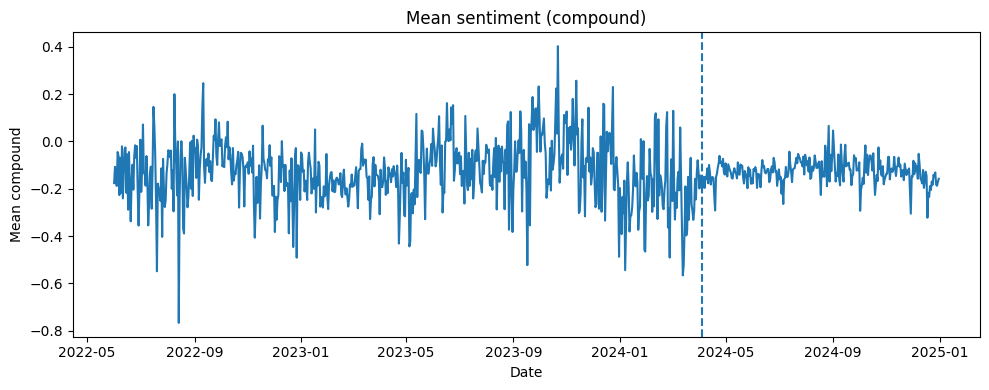

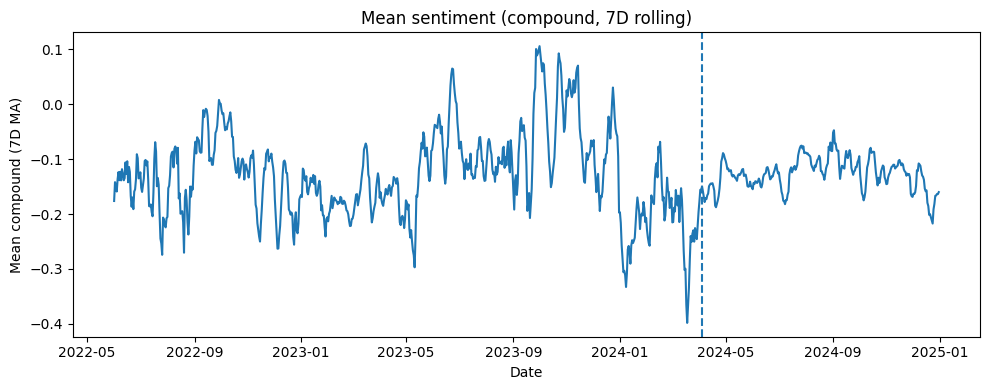

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) Deduplicate columns (keep the last occurrence)
df = df.loc[:, ~pd.Index(df.columns).duplicated(keep='last')].copy()
# (Alternative to collapse duplicates by "last non-null":
# df = df.T.groupby(level=0).last().T.copy())

# 1) Predefine your known columns
TEXT_COL = "text"
TIME_COL = "createdAt"
LANG_COL = "lang"
RT_COL   = "is_retweet"

# 2) Normalize time, clean, and (re)derive date
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=True).dt.tz_convert(None)
df = df.dropna(subset=[TIME_COL]).sort_values(TIME_COL).reset_index(drop=True)
df["date"] = df[TIME_COL].dt.normalize()   # safer than trusting existing 'date' strings

# 3) Ensure numeric types for metrics used below
for c in ["sent_compound","tone_fear","tone_uncertainty","tone_urgency","tone_safety_trust"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Daily aggregates
daily = (
    df.groupby("date", dropna=True)
      .agg(
          posts=("date","size"),
          mean_compound=("sent_compound","mean"),
          fear=("tone_fear","sum"),
          uncertainty=("tone_uncertainty","sum"),
          urgency=("tone_urgency","sum"),
          safety_trust=("tone_safety_trust","sum")
      )
      .reset_index()
)

daily["date"] = pd.to_datetime(daily["date"])
daily = daily.sort_values("date")
daily["posts_7d"]    = daily["posts"].rolling(7, min_periods=1).mean()
daily["compound_7d"] = daily["mean_compound"].rolling(7, min_periods=1).mean()

# 5) Plot with 1-D arrays (prevents the '.name' issue)
x        = daily["date"].to_numpy()
y_posts  = daily["posts"].to_numpy()
y_posts7 = daily["posts_7d"].to_numpy()
y_comp   = daily["mean_compound"].to_numpy()
y_comp7  = daily["compound_7d"].to_numpy()

ANNOUNCE_DATE = pd.Timestamp("2024-04-04")
announce_ts = pd.Timestamp(ANNOUNCE_DATE)

plt.figure(figsize=(10,4))
plt.plot(x, y_posts)
plt.axvline(announce_ts, linestyle="--")
plt.title("Posts per day (dashed = 2024-04-04)")
plt.xlabel("Date"); plt.ylabel("Posts")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, y_posts7)
plt.axvline(announce_ts, linestyle="--")
plt.title("Posts per day (7D rolling)")
plt.xlabel("Date"); plt.ylabel("Posts (7D MA)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, y_comp)
plt.axvline(announce_ts, linestyle="--")
plt.title("Mean sentiment (compound)")
plt.xlabel("Date"); plt.ylabel("Mean compound")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, y_comp7)
plt.axvline(announce_ts, linestyle="--")
plt.title("Mean sentiment (compound, 7D rolling)")
plt.xlabel("Date"); plt.ylabel("Mean compound (7D MA)")
plt.tight_layout(); plt.show()


## Save optional CSVs

In [ ]:
OUT_DIR = "data/processed"
os.makedirs(OUT_DIR, exist_ok=True)
daily.to_csv(os.path.join(OUT_DIR, "daily_aggregates.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR, "daily_aggregates.csv"))

**Overall tone is negative.** The 7-day rolling mean of VADER’s compound score stays mostly below 0 the entire period (≈ −0.05 to −0.25), so discourse about H5N1 is generally unfavorable/anxious.

* **A pronounced dip precedes the CDC announcement.** From late-2023 into Feb–Mar 2024 there’s a deep trough (≈ −0.30 to −0.40) and higher volatility. That’s the darkest period on the plot and it **occurs before** the dashed line (Apr 4, 2024). This suggests elevated concern/uncertainty in the weeks leading up to the announcement.

* **Right after the announcement the tone rebounds slightly but stays negative.** Around the dashed line there’s a small upward inflection (less negative), then the series stabilizes in a mildly negative band (roughly −0.10 to −0.18). Volatility also looks a bit lower than the immediate pre-announcement period.

* **No dramatic regime shift at the exact date.** You don’t see a sharp, sustained change exactly on Apr 4; rather, the **biggest change (the trough)** seems to happen **before** it. The post period trends modestly negative with smaller swings.

### What this may imply

* There’s potential early-warning signal in tone: a significant negative drift appears weeks before Apr 4. Combined with volume/fear/uncertainty features, this could be useful for a pre-announcement alert score.
* The announcement may have **tempered sentiment volatility** (communication effect), but did not push sentiment positive.

### Sanity checks and follow-ups (quick wins)

* Compare pre vs post means/medians** and run Mann–Whitney U (you already have this machinery).
* Look at fear/uncertainty** series alongside this plot—do they also spike ahead of Apr 4?
* Try engagement-weighted mean sentiment and a median series to test robustness.
* Run a simple changepoint/structural-break test around late-2023 to early-2024 to formalize the trough timing.
